# Exploring input noise and output normalization to make the network more rubust to perturbations

Because I think (...) that this is the cause of the crash.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from cbrain.imports import *
from cbrain.utils import *
from cbrain.data_generator import *
limit_mem()

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Use the most promising model
mpath18 = '/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/B018_purecrm_essv2_nonorm_sample1_max_rs.h5'

In [4]:
data_dir = '/scratch/srasp/preprocessed_data/'
train_pre = 'purecrm_essv2_nonorm_train_sample1_shuffle'
valid_pre = 'purecrm_essv2_nonorm_valid_sample1'
norm_fn = 'purecrm_essv2_nonorm_train_sample1_norm.nc'

In [5]:
train_gen = DataGenerator(data_dir, train_pre+'_features.nc', train_pre+'_targets.nc', 1024, 
                          norm_fn, fsub='feature_means', fdiv='max_rs', tmult='target_conv')

Generator will have 23494656 samples in 22944 batches
Features have shape 152; targets have shape 120


In [6]:
valid_gen = DataGenerator(data_dir, valid_pre+'_features.nc', valid_pre+'_targets.nc', 1024, 
                          norm_fn, fsub='feature_means', fdiv='max_rs', tmult='target_conv',
                          shuffle=False)

Generator will have 23494656 samples in 22944 batches
Features have shape 152; targets have shape 120


In [7]:
m18 = keras.models.load_model(mpath18)

## Check out output norms

This is to find out what a good output normalization would be. The idea of output normalization is that small noise in the outputs amplifies. Output normalization would multiply values which should be small (from training stats) by a small number.

In [8]:
norm = xr.open_dataset(data_dir + norm_fn); norm

<xarray.Dataset>
Dimensions:              (feature_lev: 152, target_lev: 120)
Coordinates:
  * feature_lev          (feature_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
  * target_lev           (target_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
Data variables:
    feature_means        (feature_lev) float32 ...
    feature_stds         (feature_lev) float32 ...
    feature_mins         (feature_lev) float32 ...
    feature_maxs         (feature_lev) float32 ...
    target_means         (target_lev) float32 ...
    target_stds          (target_lev) float32 ...
    target_mins          (target_lev) float32 ...
    target_maxs          (target_lev) float32 ...
    feature_names        (feature_lev) object ...
    target_names         (target_lev) object ...
    feature_stds_by_var  (feature_lev) float32 ...
    target_conv          (target_lev) float32 ...
Attributes:
    log:      \n    Time: 2018-02-27T11:13:54\n\n    Executed command:\n\n   ...

Output order: `[SPDQ, SPDT, QRL, QRS]`

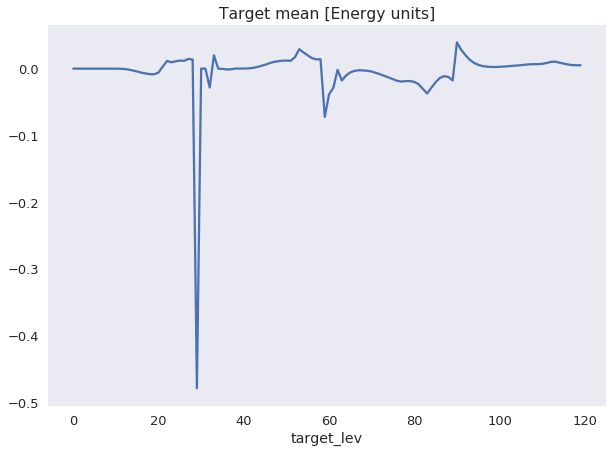

In [9]:
(norm['target_means']*norm['target_conv']).plot();
plt.title('Target mean [Energy units]');

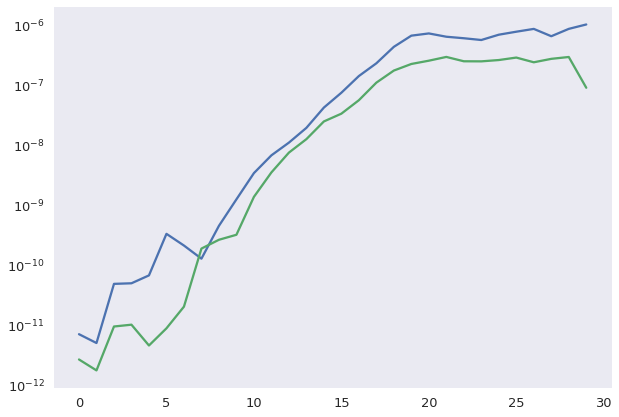

In [33]:
plt.plot(-norm['feature_mins'][120:150])
plt.plot(-np.min(d25['dQdtadia'][-1].values.reshape(30, -1).T, 0))
plt.gca().set_yscale('log')

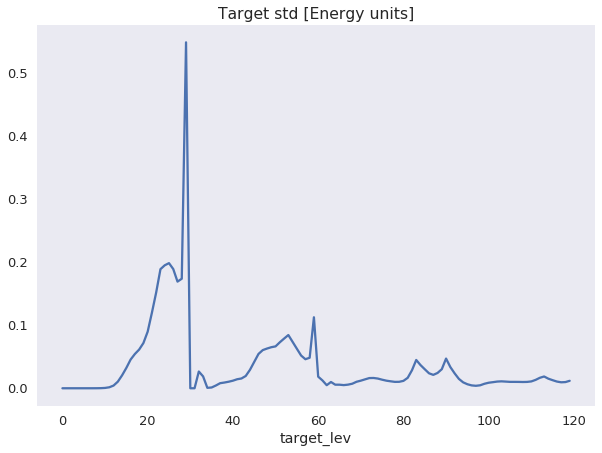

In [10]:
(norm['target_stds']*norm['target_conv']).plot();
plt.title('Target std [Energy units]');

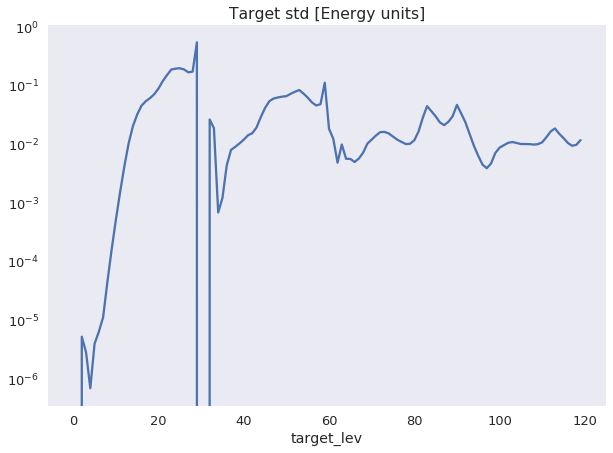

In [11]:
(norm['target_stds']*norm['target_conv']).plot()
plt.gca().set_yscale('log')
plt.title('Target std [Energy units]');

In [12]:
targets = xr.open_dataset(data_dir + train_pre+'_targets.nc').targets.isel(sample=slice(0, 100_000)) 
targets

<xarray.DataArray 'targets' (sample: 100000, target_lev: 120)>
[12000000 values with dtype=float32]
Coordinates:
  * target_lev  (target_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Dimensions without coordinates: sample

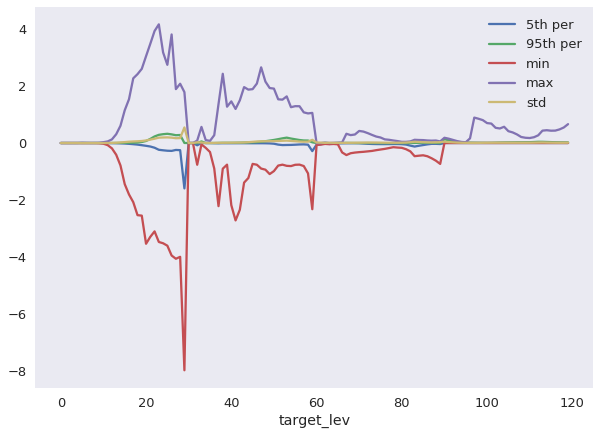

In [13]:
plt.plot(np.percentile(targets, 5, 0)*norm['target_conv'], label='5th per')
plt.plot(np.percentile(targets, 95, 0)*norm['target_conv'], label='95th per')
(norm['target_mins']*norm['target_conv']).plot(label='min')
(norm['target_maxs']*norm['target_conv']).plot(label='max')
(norm['target_stds']*norm['target_conv']).plot(label='std')
plt.legend();

**Some conclusions**
- Some standard deviation values are zero --> Cannot normalize with these.
- Min/max range is much larger than std --> Would make sigmoid output very difficult
    - 5-95th percentiles much closer to std --> Would this be an option?
    

## How sensitive is the model to perturbations in the input data?

inputs : [T_C, Q_C, V_C, dTdt_adiabatic, dQdt_adiabatic, PS, SOLIN]

outputs : [SPDQ, SPDT, QRL, QRS]

## How sensitive is the model to perturbations in the input data?

In [14]:
p = m18.predict_generator(valid_gen.return_generator(), 100)

In [15]:
p.shape

(102400, 120)

In [16]:
np.max(p, axis=0).shape

(120,)

In [17]:
d25 = xr.open_dataset('/scratch/srasp/debug/AndKua_aqua_SPCAM3.0_debug25.cam2.h1.0000-01-01-00000.nc',
                      decode_times=False)

In [19]:
a = d25['BRAINDQ'][-1].values.reshape(30, -1).T * norm['target_conv'].values[:30]
a.shape

(8192, 30)

In [21]:
b = d25['BRAINDT'][-1].values.reshape(30, -1).T * norm['target_conv'].values[30:60]

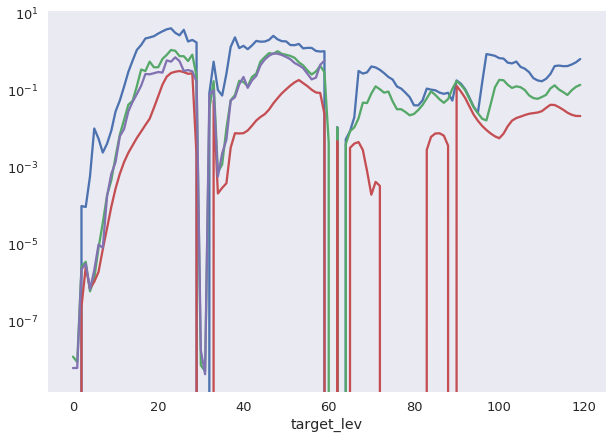

In [22]:
(norm['target_maxs']*norm['target_conv']).plot()
plt.plot(np.max(p, 0))
plt.plot(np.percentile(targets, 95, 0)*norm['target_conv'], label='95th per')
plt.plot(np.max(np.concatenate([a, b], 1), 0))
plt.gca().set_yscale('log')

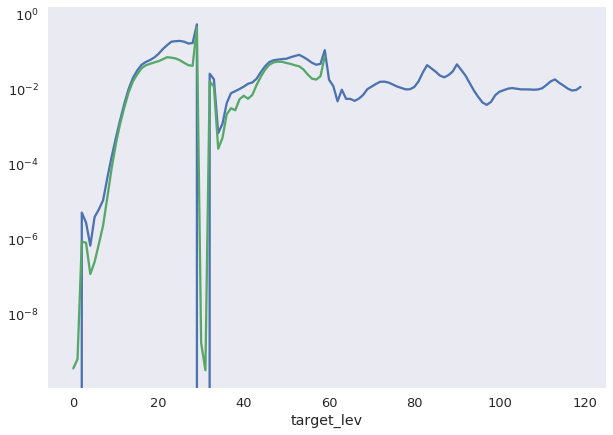

In [23]:
(norm['target_stds']*norm['target_conv']).plot()
plt.plot(np.std(np.concatenate([a, b], 1), 0))
plt.gca().set_yscale('log')

In [35]:
idx = -1

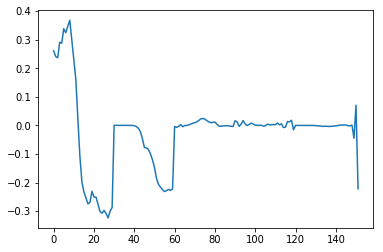

In [36]:
plt.plot(f[idx])

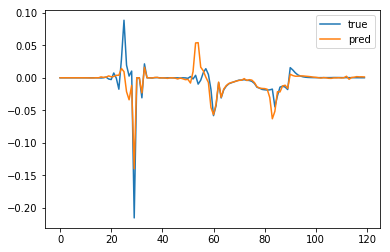

In [37]:
plt.plot(t[idx], label='true'); plt.plot(p[idx], label='pred'); plt.legend();

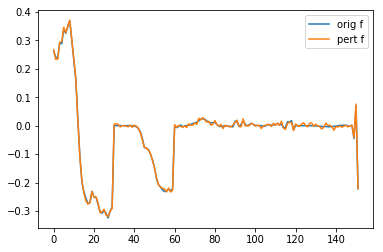

In [68]:
fpert = np.copy(f[idx])
fpert[:] += np.random.normal(0, 0.005, 152)
plt.plot(f[idx], label='orig f'); plt.plot(fpert, label='pert f'); plt.legend();

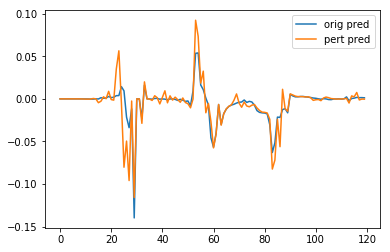

In [69]:
ppert = model.predict_on_batch(fpert[None])
plt.plot(p[idx], label='orig pred'); plt.plot(ppert[idx], label='pert pred'); plt.legend();

### Does adding input noise help?

In [71]:
mnoise = keras.models.load_model('/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/B020_purecrm_essv2_nonorm_sample1_noise1.h5')

In [73]:
mnoise.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               78336     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 139,896
Trainable params: 139,896
Non-trainable params: 0
_________________________________________________________________


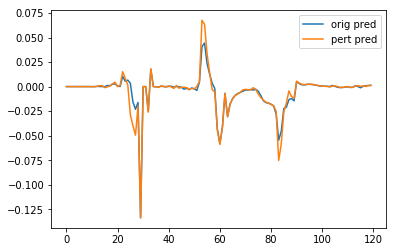

In [77]:
p_noise = mnoise.predict_on_batch(f)
ppert_noise = mnoise.predict_on_batch(fpert[None])
plt.plot(p_noise[idx], label='orig pred'); plt.plot(ppert_noise[idx], label='pert pred'); 
plt.legend();

Yes, definitely makes noisy input predictions smoother. Not sure it is enough but worth a try.

### Does dropout help?

In [78]:
mdrop = keras.models.load_model('/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/B021_purecrm_essv2_nonorm_sample1_dr1.h5')

In [79]:
mdrop.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               78336     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 139,896
Trainable params: 139,896
Non-trainable params: 0
_________________________________________________________________


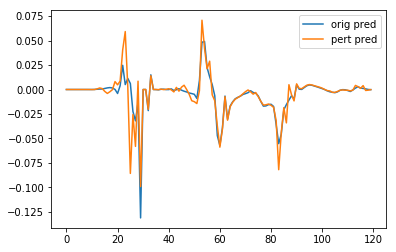

In [80]:
p_drop = mdrop.predict_on_batch(f)
ppert_drop = mdrop.predict_on_batch(fpert[None])
plt.plot(p_drop[idx], label='orig pred'); plt.plot(ppert_drop[idx], label='pert pred'); 
plt.legend();

In [ ]:
# Better dropout?

In [81]:
mdrop = keras.models.load_model('/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/B022_purecrm_essv2_nonorm_sample1_dr2_deep.h5')

In [82]:
mdrop.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               78336     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               61560     
Total params: 402,552
Trainable params: 402,552
Non-trainable params: 0
_________________________________________________________________


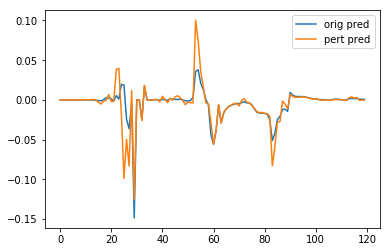

In [83]:
p_drop = mdrop.predict_on_batch(f)
ppert_drop = mdrop.predict_on_batch(fpert[None])
plt.plot(p_drop[idx], label='orig pred'); plt.plot(ppert_drop[idx], label='pert pred'); 
plt.legend();

Dropout doesn't really seem to help with the robustness.